<a href="https://colab.research.google.com/github/LeeHuiJong/SkillTreePython-DataAnalysis/blob/main/ch05_13_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.13. 사이킷런 실습 - 앙상블

---
* 날짜:
* 이름:

## 학습내용
    - 모델 앙상블에 대한 개념을 이해한다.
    - 배깅(bagging) : 부트스트랩(bootstrp) 샘플링을 통한 분류 앙상블 기법을 이해한다.
    - 부스팅 기반의 에이다부스트(AdaBoost) 알고리즘을 이해한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 7장. 다양한 모델을 결합한 앙상블 학습

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

#### 데이터 가져오기

In [16]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [6]:
df_wine.shape

(178, 14)

In [8]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [11]:
df_wine.Alcohol.value_counts()

13.05    6
12.37    6
12.08    5
12.29    4
12.42    3
        ..
13.72    1
13.29    1
13.74    1
13.77    1
14.13    1
Name: Alcohol, Length: 126, dtype: int64

#### 학습을 위한 데이터 처리
* 와인 클래스 2와 클래스 3만 사용 (1은 제거)
* 두개의 특성 Alcohol과 'OD280/OD315 of diluted wines'만 사용

In [18]:
# 클래스 라벨 1인 샘플은 제거(2,3만 남음)
mask = df_wine['Class label'] != 1
df_wine = df_wine[mask]
# X y 로 구분(X는 두개 특성 사용)
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values
X.shape, y.shape

((119, 2), (119,))

#### 전처리

In [20]:
from sklearn.preprocessing import LabelEncoder
# 라벨 인코딩 {1, 2} -> {0, 1}
le = LabelEncoder()
y = le.fit_transform(y)

# 훈련, 테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95, 2), (24, 2), (95,), (24,))

#### 분포 시각화

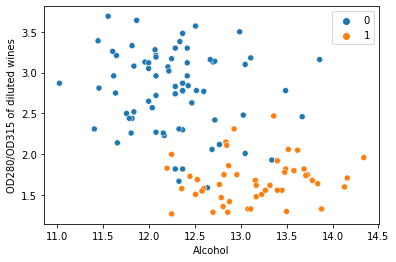

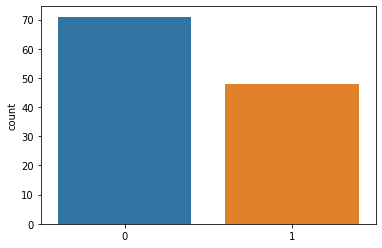

In [32]:
# 속성 1,2  산점도(x)
feature1 = X[:,0]
feature2 = X[:,1]
sns.scatterplot(x=feature1, y=feature2, hue = y)
plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')
plt.show()

# 클래스(y)별 개수(countplot)
sns.countplot(x=y)
plt.show()

## 다수결 투표 방식을 사용한 예측
---

<p align='center'>
<img src=https://git.io/Jtskl?raw=true width=600>
</p>



#### 모델 구성

In [68]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(random_state = 1,
                        penalty = 'l2')
tree = DecisionTreeClassifier(max_depth = 1,
                              criterion = 'entropy',
                              random_state = 1)
knn = KNeighborsClassifier(n_neighbors = 1,
                           p = 2,
                           metric = 'minkowski')

voting = VotingClassifier(estimators = [('logistic', lr),
                                        ('tree', tree),
                                        ('knn', knn)], 
                                        voting = 'soft') # {hard, soft(확률 평균값 판단.)}
models = ['lr', 'tree', 'knn', 'voting']

#### k-겹 교차검증

In [69]:
from sklearn.model_selection import cross_val_score

print('10겹 교차검증:')
for model in models:
  scores = cross_val_score(estimator = eval(model),
                           X = X_train, y = y_train,
                           cv = 10,
                           scoring = 'accuracy')
  print(f'{model} Accuracy:{scores.mean():.2f} (+/-{scores.std():.2f})')

10겹 교차검증:
lr Accuracy:0.88 (+/-0.13)
tree Accuracy:0.88 (+/-0.09)
knn Accuracy:0.91 (+/-0.11)
voting Accuracy:0.93 (+/-0.11)


#### 스코어 계산

In [70]:
for model in models:
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Train Accuracy : {train_score:.2f} {model} Test score : {test_score:.2f}')

lr Train Accuracy : 0.89 lr Test score : 0.92
tree Train Accuracy : 0.92 tree Test score : 0.88
knn Train Accuracy : 1.00 knn Test score : 0.92
voting Train Accuracy : 0.96 voting Test score : 0.92


#### 모델 별 결정경계 시각화

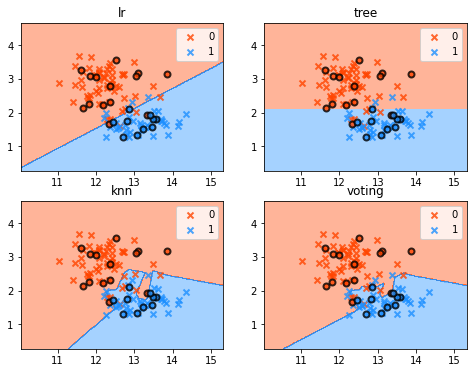

In [46]:
plt.figure(figsize = (8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 배깅(Bagging: Bootrstrap aggregating)
----

<p align='center'>
<img src=https://git.io/Jtsk4?raw=true width=500>
</p>

#### 모델 구성

```
sklearn.ensemble.BaggingClassifier(
                                  base_estimator=None, 
                                  n_estimators=10, *, 
                                  max_samples=1.0, 
                                  max_features=1.0, 
                                  bootstrap=True, 
                                  bootstrap_features=False, 
                                  oob_score=False, 
                                  warm_start=False, 
                                  n_jobs=None, 
                                  random_state=None, 
                                  verbose=0

```

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = None,
                              random_state = 1)
bagging = BaggingClassifier(base_estimator = tree,
                            n_estimators = 500,
                            random_state = 1)
models = ['tree', 'bagging']

#### k-겹 교차검증

In [72]:
print('10겹 교차검증:')
for model in models:
  scores = cross_val_score(estimator = eval(model),
                           X = X_train, y = y_train,
                           cv = 10,
                           scoring = 'accuracy')
  print(f'{model} Accuracy:{scores.mean():.2f} (+/-{scores.std():.2f})')

10겹 교차검증:
tree Accuracy:0.88 (+/-0.12)
bagging Accuracy:0.90 (+/-0.10)


#### 스코어 계산

In [73]:
for model in models:
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Train Accuracy : {train_score:.2f} {model} Test score : {test_score:.2f}')

tree Train Accuracy : 1.00 tree Test score : 0.83
bagging Train Accuracy : 1.00 bagging Test score : 0.92


#### 모델 별 분류경계 시각화

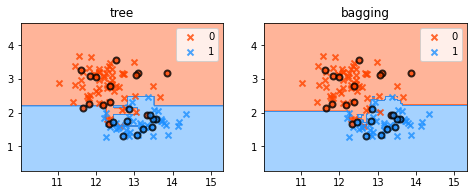

In [74]:
plt.figure(figsize = (8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

##  에이다부스트(AdaBoost)
---


<p align='center'>
<img src=https://camo.githubusercontent.com/e0966809177c396bd5f64c2142e11ca7f31dfb05094ac671c5f425fbd2cd2f91/68747470733a2f2f6769742e696f2f4a74736b30?raw=true width=500>
</p>

#### 모델구성

```
class sklearn.ensemble.AdaBoostClassifier(
                          base_estimator=None, *, 
                          n_estimators=50, 
                          learning_rate=1.0, 
                          algorithm='SAMME.R', 
                          random_state=None)[source]¶

```

In [65]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 1,
                              random_state = 1)
ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,
                         learning_rate = 0.1,
                         random_state = 1)
models = ['tree', 'ada']

#### k-겹 교차검증

In [61]:
print('10겹 교차검증:')
for model in models:
  scores = cross_val_score(estimator = eval(model),
                           X = X_train, y = y_train,
                           cv = 10,
                           scoring = 'accuracy')
  print(f'{model} Accuracy:{scores.mean():.2f} (+/-{scores.std():.2f})')

10겹 교차검증:
tree Accuracy:0.88 (+/-0.12)
bagging Accuracy:0.90 (+/-0.10)


#### 스코어 계산

In [66]:
for model in models:
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Train Accuracy : {train_score:.2f} {model} Test score : {test_score:.2f}')

tree Train Accuracy : 0.92 tree Test score : 0.88
ada Train Accuracy : 1.00 ada Test score : 0.92


#### 모델 별 분류경계 시각화

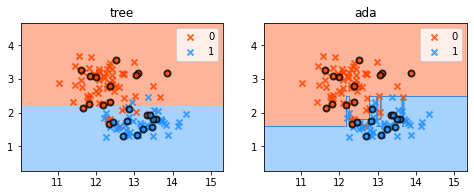

In [67]:
plt.figure(figsize = (8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 앙상블 모델 정리
---

In [76]:
from pandas.core.common import random_state
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = None,
                              random_state = 1)

rnd_tree = RandomForestClassifier(random_state = 1)

bagging = BaggingClassifier(base_estimator = tree,
                            n_estimators = 500,
                            random_state = 1)

ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,
                         learning_rate = 0.1,
                         random_state = 1)

# 그래디언트 부스팅 랜덤 트리
gbrt = GradientBoostingClassifier(random_state = 1)

# xgboost
xgb = XGBClassifier(random_state = 1)

#light bgm
lgb = LGBMClassifier(random_state = 1)

models = ['tree', 'rnd_tree', 'bagging', 'ada', 'gbrt', 'xgb', 'lgb']

#### k-겹 교차검증

In [77]:
print('10겹 교차검증:')
for model in models:
  scores = cross_val_score(estimator = eval(model),
                           X = X_train, y = y_train,
                           cv = 10,
                           scoring = 'accuracy')
  print(f'{model} Accuracy:{scores.mean():.2f} (+/-{scores.std():.2f})')

10겹 교차검증:
tree Accuracy:0.88 (+/-0.12)
rnd_tree Accuracy:0.90 (+/-0.10)
bagging Accuracy:0.90 (+/-0.10)
ada Accuracy:0.85 (+/-0.13)
gbrt Accuracy:0.84 (+/-0.11)
xgb Accuracy:0.90 (+/-0.09)
lgb Accuracy:0.91 (+/-0.10)


#### 스코어 계산

In [78]:
for model in models:
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Train Accuracy : {train_score:.2f} {model} Test score : {test_score:.2f}')

tree Train Accuracy : 1.00 tree Test score : 0.83
rnd_tree Train Accuracy : 1.00 rnd_tree Test score : 0.92
bagging Train Accuracy : 1.00 bagging Test score : 0.92
ada Train Accuracy : 1.00 ada Test score : 0.83
gbrt Train Accuracy : 1.00 gbrt Test score : 0.92
xgb Train Accuracy : 0.97 xgb Test score : 0.92
lgb Train Accuracy : 0.97 lgb Test score : 0.92


#### 모델 별 분류경계 시각화

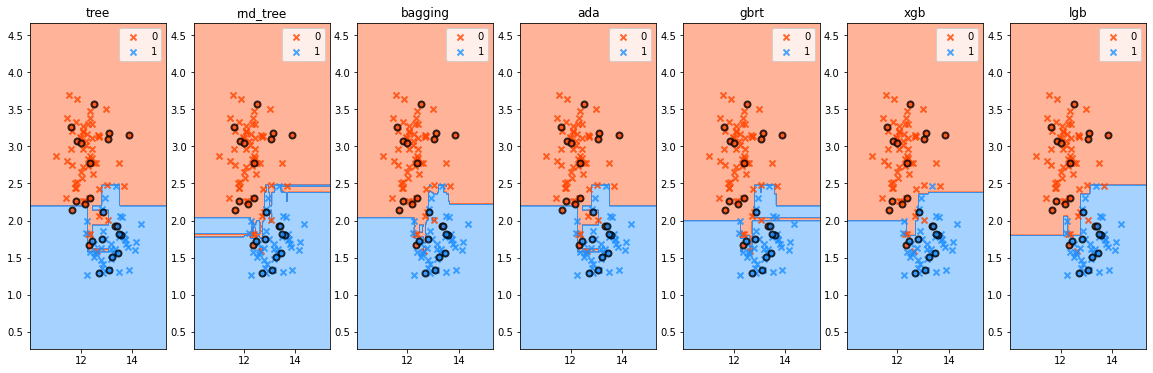

In [79]:
plt.figure(figsize = (20,6))
for i, model in enumerate(models):
  plt.subplot(1,7,i+1)
  draw_decision_region(eval(model),
                       X_train, y_train,
                       X_test, y_test,
                       title = model)
plt.show()

## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Bossting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터